In [2]:
import os, zipfile, random, shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from collections import Counter

In [5]:
# SMART EXTRACTION + FOLDER DETECTION FIX

import zipfile, shutil, os
from pathlib import Path

# Define paths
DATA_ROOT = Path("./data_extracted_fixed")
TRAIN_ZIP = r"D:\Guvi Projects\6. Brain Tumour Classification\train-20251115T064719Z-1-001.zip"
VALID_ZIP = r"D:\Guvi Projects\6. Brain Tumour Classification\valid-20251115T064723Z-1-001.zip"
TEST_ZIP  = r"D:\Guvi Projects\6. Brain Tumour Classification\test-20251115T064717Z-1-001.zip"

# Clean old extraction if exists
if DATA_ROOT.exists():
    shutil.rmtree(DATA_ROOT)
DATA_ROOT.mkdir(parents=True, exist_ok=True)

def smart_extract(zip_path, target_dir):
    """Extract zip and automatically detect the actual 'train/valid/test' folder level."""
    print(f"Extracting {zip_path} ...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(target_dir)
    print(f"Extracted to {target_dir}")

    # Find the real dataset folder (contains class subfolders)
    # e.g., /data/train/train/...  or /data/train/...
    candidates = list(Path(target_dir).rglob("train"))
    if not candidates:
        candidates = list(Path(target_dir).rglob("Train"))
    if candidates:
        print(f"Found train folder candidate: {candidates[0]}")
    return target_dir

# Extract all datasets
smart_extract(TRAIN_ZIP, DATA_ROOT / "train")
smart_extract(VALID_ZIP, DATA_ROOT / "valid")
smart_extract(TEST_ZIP,  DATA_ROOT / "test")

# Detect the deepest actual directories that contain class folders
def find_actual_dataset_dir(base_dir):
    base_dir = Path(base_dir)
    subdirs = [p for p in base_dir.rglob("*") if p.is_dir() and any(f.suffix.lower() in ['.jpg', '.jpeg', '.png'] for f in p.glob("*"))]
    if subdirs:
        # Return parent folder containing class folders
        parents = {p.parent for p in subdirs}
        best = min(parents, key=lambda p: len(p.parts))
        print(f"✅ Found valid dataset directory: {best}")
        return best
    else:
        print(f"⚠️ No images found under {base_dir}, check your zip structure.")
        return base_dir

TRAIN_DIR = find_actual_dataset_dir(DATA_ROOT / "train")
VALID_DIR = find_actual_dataset_dir(DATA_ROOT / "valid")
TEST_DIR  = find_actual_dataset_dir(DATA_ROOT / "test")

print(f"\nFinal dataset directories:")
print(f"Train dir: {TRAIN_DIR}")
print(f"Valid dir: {VALID_DIR}")
print(f"Test dir:  {TEST_DIR}")

# Quick verification
for root, dirs, files in os.walk(TRAIN_DIR):
    print(f"\nSample structure check:\n{root} -> {len(dirs)} class folders")
    print("Classes:", dirs)
    break

Extracting D:\Guvi Projects\6. Brain Tumour Classification\train-20251115T064719Z-1-001.zip ...
Extracted to data_extracted_fixed\train
Found train folder candidate: data_extracted_fixed\train\train
Extracting D:\Guvi Projects\6. Brain Tumour Classification\valid-20251115T064723Z-1-001.zip ...
Extracted to data_extracted_fixed\valid
Extracting D:\Guvi Projects\6. Brain Tumour Classification\test-20251115T064717Z-1-001.zip ...
Extracted to data_extracted_fixed\test
✅ Found valid dataset directory: data_extracted_fixed\train\train
✅ Found valid dataset directory: data_extracted_fixed\valid\valid
✅ Found valid dataset directory: data_extracted_fixed\test\test

Final dataset directories:
Train dir: data_extracted_fixed\train\train
Valid dir: data_extracted_fixed\valid\valid
Test dir:  data_extracted_fixed\test\test

Sample structure check:
data_extracted_fixed\train\train -> 4 class folders
Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']


In [6]:
# 1) CONFIG

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

DATA_ROOT = Path("data_extracted_fixed")   # already extracted (from your previous step)
TRAIN_DIR = DATA_ROOT / "train" / "train"
VALID_DIR = DATA_ROOT / "valid" / "valid"
TEST_DIR  = DATA_ROOT / "test" / "test"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15
OUTPUT_DIR = Path("models_outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

In [7]:
# 2️) DATA PREPROCESSING (Fixed for RGB inputs)

print("✅ Preparing datasets...")

def create_dataset(directory, img_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels="inferred",
        label_mode="int",
        batch_size=batch_size,
        image_size=img_size,
        shuffle=shuffle,
        seed=SEED,
        color_mode="rgb"   # 👈 Force 3-channel RGB to avoid grayscale mismatch
    )
    return ds

train_ds = create_dataset(TRAIN_DIR)
val_ds   = create_dataset(VALID_DIR, shuffle=False)
test_ds  = create_dataset(TEST_DIR, shuffle=False)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# ✅ Sanity check: verify image shape
for images, labels in train_ds.take(1):
    print(f"Sample image batch shape: {images.shape}")
    print(f"Sample label batch shape: {labels.shape}")

# Normalize pixel values to [0–1]
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Prefetch for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
     

✅ Preparing datasets...
Found 1695 files belonging to 4 classes.
Found 502 files belonging to 4 classes.
Found 246 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Sample image batch shape: (32, 224, 224, 3)
Sample label batch shape: (32,)


In [8]:
# 3️) DATA AUGMENTATION

print("✅ Setting up augmentation...")
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1)
], name="data_augmentation")
     

✅ Setting up augmentation...


In [9]:
# 4️) MODEL BUILDING (Fixed & Verified)

print("✅ Building models...")

# ---- Custom CNN ----
def build_custom_cnn(input_shape=(224,224,3), num_classes=4):
    model = models.Sequential([
        data_augmentation,
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

custom_cnn = build_custom_cnn((224,224,3), num_classes)
custom_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
custom_cnn.summary()

# ---- Transfer Learning Models ----
def build_transfer_model(base_model, num_classes=4):
    base_model.trainable = False
    inputs = layers.Input(shape=(224,224,3))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

transfer_models = {
    "ResNet50": build_transfer_model(applications.ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3)), num_classes),
    "MobileNetV2": build_transfer_model(applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3)), num_classes),
    "InceptionV3": build_transfer_model(applications.InceptionV3(weights="imagenet", include_top=False, input_shape=(224,224,3)), num_classes),
}
     

✅ Building models...


d:\Guvi Projects\6. Brain Tumour Classification\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 27s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step


✅ Training models...

Training CustomCNN ...
Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4410 - loss: 1.5920

53/53 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - accuracy: 0.5115 - loss: 1.3572 - val_accuracy: 0.2470 - val_loss: 1.3641
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5716 - loss: 1.1696

53/53 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.5841 - loss: 1.1554 - val_accuracy: 0.2351 - val_loss: 1.3502
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.6094 - loss: 1.1016 - val_accuracy: 0.2390 - val_loss: 1.3859
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.6271 - loss: 1.0245 - val_accuracy: 0.3167 - val_loss: 1.4685
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.6372 - loss: 1.0412 - val_accuracy: 0.5139 - val_loss: 1.5165
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.6383 - loss: 0.9877 - val_accuracy: 0.5179 - val_loss: 1.4931


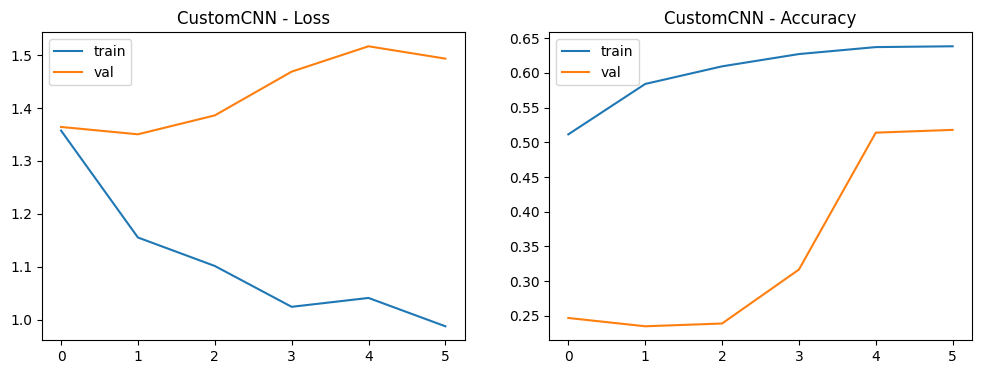


Training ResNet50 ...
Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2654 - loss: 2.0128

53/53 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.2519 - loss: 1.8537 - val_accuracy: 0.2430 - val_loss: 1.4341
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2706 - loss: 1.5187

53/53 ━━━━━━━━━━━━━━━━━━━━ 191s 4s/step - accuracy: 0.2737 - loss: 1.5101 - val_accuracy: 0.3287 - val_loss: 1.3576
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2732 - loss: 1.5122

53/53 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.2820 - loss: 1.4941 - val_accuracy: 0.3566 - val_loss: 1.3449
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3041 - loss: 1.4627

53/53 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - accuracy: 0.2885 - loss: 1.4702 - val_accuracy: 0.3745 - val_loss: 1.3339
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3173 - loss: 1.4321

53/53 ━━━━━━━━━━━━━━━━━━━━ 1946s 37s/step - accuracy: 0.3044 - loss: 1.4410 - val_accuracy: 0.3865 - val_loss: 1.3195
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3121 - loss: 1.4291

53/53 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.2932 - loss: 1.4440 - val_accuracy: 0.4104 - val_loss: 1.3147
Epoch 7/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3246 - loss: 1.4287

53/53 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.3127 - loss: 1.4346 - val_accuracy: 0.4104 - val_loss: 1.3011
Epoch 8/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 181s/step - accuracy: 0.3284 - loss: 1.4277  

53/53 ━━━━━━━━━━━━━━━━━━━━ 9463s 182s/step - accuracy: 0.3369 - loss: 1.4061 - val_accuracy: 0.4203 - val_loss: 1.2920
Epoch 9/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3277 - loss: 1.3920

53/53 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.3381 - loss: 1.3899 - val_accuracy: 0.4104 - val_loss: 1.2830
Epoch 10/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3231 - loss: 1.4017

53/53 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.3398 - loss: 1.3897 - val_accuracy: 0.4283 - val_loss: 1.2743
Epoch 11/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 529s/step - accuracy: 0.3465 - loss: 1.3745  

53/53 ━━━━━━━━━━━━━━━━━━━━ 27548s 530s/step - accuracy: 0.3381 - loss: 1.3785 - val_accuracy: 0.4303 - val_loss: 1.2650
Epoch 12/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3582 - loss: 1.3675

53/53 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.3664 - loss: 1.3613 - val_accuracy: 0.4323 - val_loss: 1.2570
Epoch 13/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3650 - loss: 1.3575

53/53 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.3658 - loss: 1.3511 - val_accuracy: 0.4382 - val_loss: 1.2504
Epoch 14/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3835 - loss: 1.3197

53/53 ━━━━━━━━━━━━━━━━━━━━ 253s 5s/step - accuracy: 0.3693 - loss: 1.3346 - val_accuracy: 0.4382 - val_loss: 1.2417
Epoch 15/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3882 - loss: 1.3230

53/53 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.3882 - loss: 1.3107 - val_accuracy: 0.4402 - val_loss: 1.2352


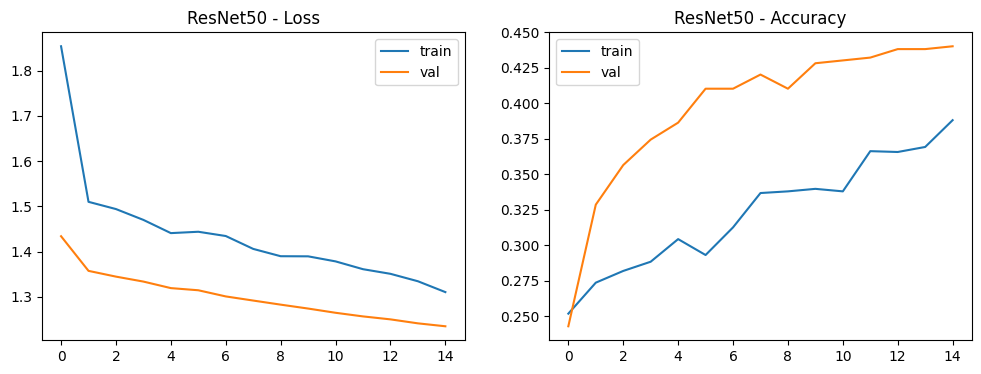


Training MobileNetV2 ...
Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.2759 - loss: 1.8072

53/53 ━━━━━━━━━━━━━━━━━━━━ 52s 864ms/step - accuracy: 0.3369 - loss: 1.5866 - val_accuracy: 0.4701 - val_loss: 1.2353
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.4830 - loss: 1.2638

53/53 ━━━━━━━━━━━━━━━━━━━━ 44s 824ms/step - accuracy: 0.4950 - loss: 1.2173 - val_accuracy: 0.5418 - val_loss: 1.1145
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.5505 - loss: 1.0786

53/53 ━━━━━━━━━━━━━━━━━━━━ 44s 827ms/step - accuracy: 0.5599 - loss: 1.0623 - val_accuracy: 0.5717 - val_loss: 1.0210
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.5977 - loss: 1.0245

53/53 ━━━━━━━━━━━━━━━━━━━━ 43s 821ms/step - accuracy: 0.5976 - loss: 0.9888 - val_accuracy: 0.5976 - val_loss: 0.9724
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.6100 - loss: 0.9637

53/53 ━━━━━━━━━━━━━━━━━━━━ 43s 819ms/step - accuracy: 0.6283 - loss: 0.9176 - val_accuracy: 0.6195 - val_loss: 0.9258
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.6404 - loss: 0.8814

53/53 ━━━━━━━━━━━━━━━━━━━━ 43s 821ms/step - accuracy: 0.6425 - loss: 0.8625 - val_accuracy: 0.6315 - val_loss: 0.8890
Epoch 7/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.6783 - loss: 0.8188

53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 854ms/step - accuracy: 0.6637 - loss: 0.8289 - val_accuracy: 0.6375 - val_loss: 0.8502
Epoch 8/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.6815 - loss: 0.8022

53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 843ms/step - accuracy: 0.6873 - loss: 0.7992 - val_accuracy: 0.6514 - val_loss: 0.8265
Epoch 9/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.7055 - loss: 0.7622

53/53 ━━━━━━━━━━━━━━━━━━━━ 44s 834ms/step - accuracy: 0.7044 - loss: 0.7554 - val_accuracy: 0.6614 - val_loss: 0.8174
Epoch 10/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.7117 - loss: 0.7065

53/53 ━━━━━━━━━━━━━━━━━━━━ 44s 829ms/step - accuracy: 0.6956 - loss: 0.7381 - val_accuracy: 0.6773 - val_loss: 0.7785
Epoch 11/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.7137 - loss: 0.7124

53/53 ━━━━━━━━━━━━━━━━━━━━ 44s 827ms/step - accuracy: 0.7180 - loss: 0.7137 - val_accuracy: 0.6813 - val_loss: 0.7658
Epoch 12/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 44s 829ms/step - accuracy: 0.7322 - loss: 0.6918 - val_accuracy: 0.6753 - val_loss: 0.7822
Epoch 13/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.7180 - loss: 0.7047

53/53 ━━━━━━━━━━━━━━━━━━━━ 44s 837ms/step - accuracy: 0.7286 - loss: 0.6696 - val_accuracy: 0.6833 - val_loss: 0.7625
Epoch 14/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.7195 - loss: 0.6925

53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 853ms/step - accuracy: 0.7469 - loss: 0.6431 - val_accuracy: 0.6873 - val_loss: 0.7525
Epoch 15/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.7555 - loss: 0.6425

53/53 ━━━━━━━━━━━━━━━━━━━━ 44s 838ms/step - accuracy: 0.7587 - loss: 0.6313 - val_accuracy: 0.6892 - val_loss: 0.7396


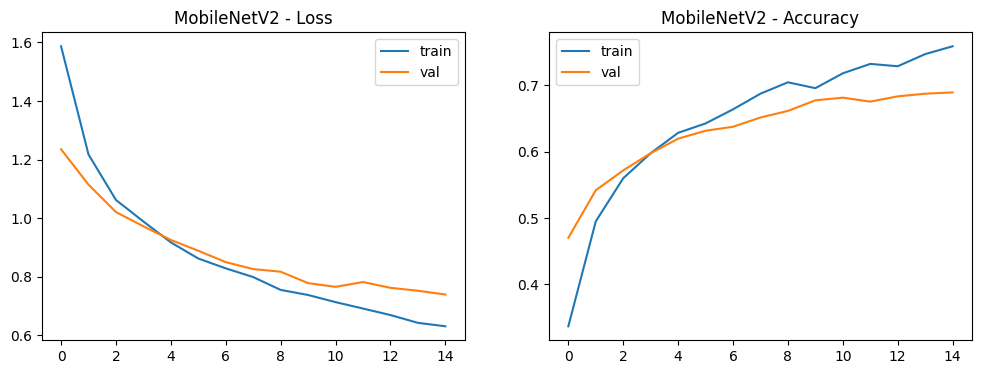


Training InceptionV3 ...
Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2486 - loss: 1.7249

53/53 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.2926 - loss: 1.5784 - val_accuracy: 0.4422 - val_loss: 1.2562
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4180 - loss: 1.3641

53/53 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.4519 - loss: 1.2943 - val_accuracy: 0.5697 - val_loss: 1.0879
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5230 - loss: 1.1346

53/53 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.5333 - loss: 1.1079 - val_accuracy: 0.6295 - val_loss: 0.9681
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5657 - loss: 1.0495

53/53 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.5799 - loss: 1.0411 - val_accuracy: 0.6633 - val_loss: 0.9007
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6109 - loss: 0.9820

53/53 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.6035 - loss: 0.9781 - val_accuracy: 0.6813 - val_loss: 0.8421
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6487 - loss: 0.8850

53/53 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.6407 - loss: 0.8994 - val_accuracy: 0.6873 - val_loss: 0.8190
Epoch 7/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6556 - loss: 0.8731

53/53 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.6678 - loss: 0.8455 - val_accuracy: 0.6873 - val_loss: 0.7988
Epoch 8/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6733 - loss: 0.8112

53/53 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.6696 - loss: 0.8226 - val_accuracy: 0.6992 - val_loss: 0.7665
Epoch 9/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6822 - loss: 0.8014

53/53 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.6826 - loss: 0.7970 - val_accuracy: 0.7092 - val_loss: 0.7510
Epoch 10/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7205 - loss: 0.7093

53/53 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.7080 - loss: 0.7339 - val_accuracy: 0.7052 - val_loss: 0.7507
Epoch 11/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7298 - loss: 0.7203

53/53 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.7233 - loss: 0.7403 - val_accuracy: 0.7271 - val_loss: 0.7032
Epoch 12/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.7186 - loss: 0.7118 - val_accuracy: 0.7271 - val_loss: 0.7097
Epoch 13/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7103 - loss: 0.7179 - val_accuracy: 0.7112 - val_loss: 0.7307
Epoch 14/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7478 - loss: 0.6606

53/53 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.7392 - loss: 0.6809 - val_accuracy: 0.7311 - val_loss: 0.6917
Epoch 15/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7603 - loss: 0.6594

53/53 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7434 - loss: 0.6766 - val_accuracy: 0.7450 - val_loss: 0.6736


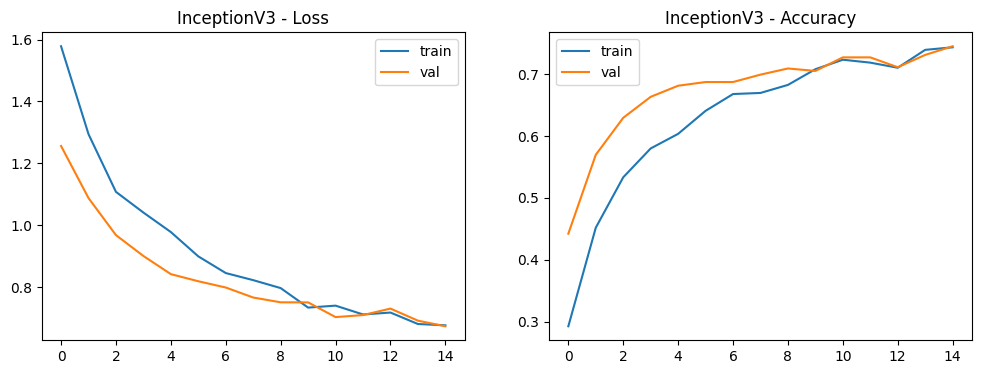

In [10]:
# 5️) MODEL TRAINING

print("✅ Training models...")
results = []

def train_model(model, name):
    print(f"\nTraining {name} ...")
    cb = [
        callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
        callbacks.ModelCheckpoint(f"{OUTPUT_DIR}/{name}_best.h5", save_best_only=True)
    ]
    model.compile(optimizer=optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=cb)
    # Plot history
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(f'{name} - Loss'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title(f'{name} - Accuracy'); plt.legend()
    plt.show()
    return model, history

# Train Custom CNN
custom_cnn, history_cnn = train_model(custom_cnn, "CustomCNN")

# Train Transfer Models
for name, model in transfer_models.items():
    model, hist = train_model(model, name)
    transfer_models[name] = model

✅ Evaluating models...


d:\Guvi Projects\6. Brain Tumour Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Guvi Projects\6. Brain Tumour Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Guvi Projects\6. Brain Tumour Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag


📊 CustomCNN Results:
Accuracy=0.2195  Precision=0.0482  Recall=0.2195  F1=0.0790
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00        80
  meningioma       0.00      0.00      0.00        63
    no_tumor       0.00      0.00      0.00        49
   pituitary       0.22      1.00      0.36        54

    accuracy                           0.22       246
   macro avg       0.05      0.25      0.09       246
weighted avg       0.05      0.22      0.08       246



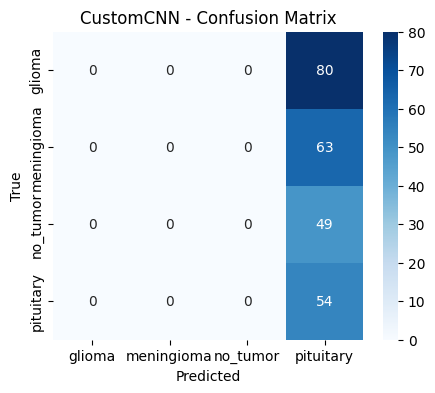

d:\Guvi Projects\6. Brain Tumour Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Guvi Projects\6. Brain Tumour Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Guvi Projects\6. Brain Tumour Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag


📊 ResNet50 Results:
Accuracy=0.4350  Precision=0.2698  Recall=0.4350  F1=0.3051
              precision    recall  f1-score   support

      glioma       0.38      1.00      0.55        80
  meningioma       0.00      0.00      0.00        63
    no_tumor       0.73      0.55      0.63        49
   pituitary       0.00      0.00      0.00        54

    accuracy                           0.43       246
   macro avg       0.28      0.39      0.30       246
weighted avg       0.27      0.43      0.31       246



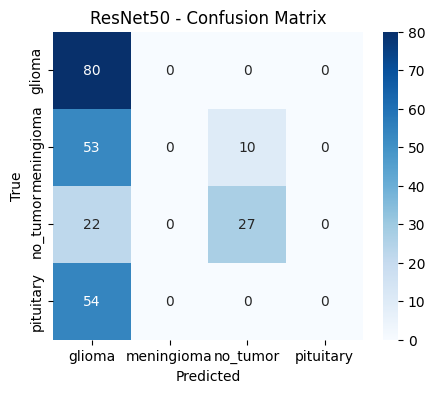


📊 MobileNetV2 Results:
Accuracy=0.6748  Precision=0.7308  Recall=0.6748  F1=0.6713
              precision    recall  f1-score   support

      glioma       0.86      0.69      0.76        80
  meningioma       0.68      0.40      0.50        63
    no_tumor       0.85      0.67      0.75        49
   pituitary       0.50      0.98      0.66        54

    accuracy                           0.67       246
   macro avg       0.72      0.68      0.67       246
weighted avg       0.73      0.67      0.67       246



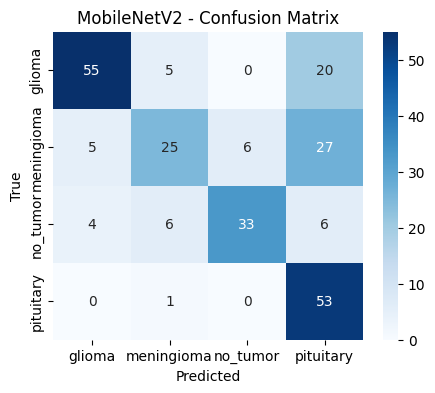


📊 InceptionV3 Results:
Accuracy=0.6992  Precision=0.7322  Recall=0.6992  F1=0.6828
              precision    recall  f1-score   support

      glioma       0.81      0.80      0.81        80
  meningioma       0.70      0.33      0.45        63
    no_tumor       0.85      0.67      0.75        49
   pituitary       0.55      1.00      0.71        54

    accuracy                           0.70       246
   macro avg       0.73      0.70      0.68       246
weighted avg       0.73      0.70      0.68       246



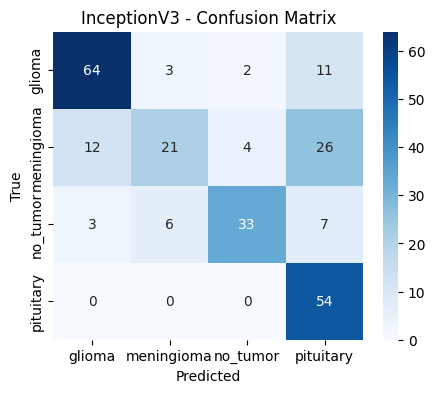

In [11]:
# 6️) MODEL EVALUATION

print("✅ Evaluating models...")

def evaluate_model(model, name):
    y_true, y_pred = [], []
    for imgs, labels in test_ds:
        preds = model.predict(imgs, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    print(f"\n📊 {name} Results:")
    print(f"Accuracy={acc:.4f}  Precision={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}")
    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()
    return {"model": name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

# Evaluate all models
results.append(evaluate_model(custom_cnn, "CustomCNN"))
for name, model in transfer_models.items():
    results.append(evaluate_model(model, name))
     


✅ Model Comparison Summary:
         model  accuracy  precision    recall        f1
3  InceptionV3  0.699187   0.732223  0.699187  0.682815
2  MobileNetV2  0.674797   0.730809  0.674797  0.671285
1     ResNet50  0.434959   0.269832  0.434959  0.305114
0    CustomCNN  0.219512   0.048186  0.219512  0.079024


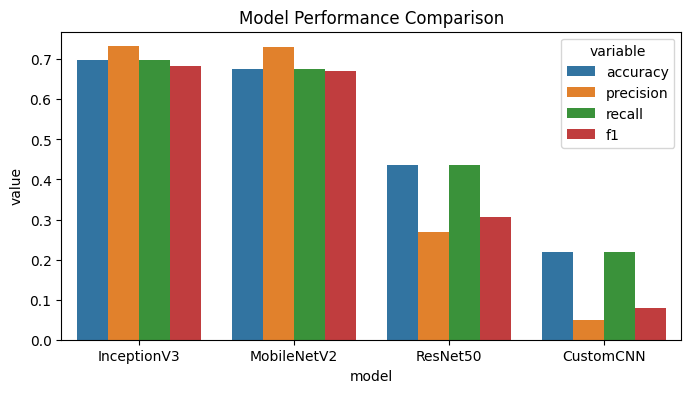


🏆 Best Performing Model: InceptionV3


In [12]:
# 7️) MODEL COMPARISON

df = pd.DataFrame(results).sort_values("f1", ascending=False)
print("\n✅ Model Comparison Summary:")
print(df)

plt.figure(figsize=(8,4))
sns.barplot(data=df.melt(id_vars='model', value_vars=['accuracy','precision','recall','f1']),
            x='model', y='value', hue='variable')
plt.title("Model Performance Comparison")
plt.show()

best_model_name = df.iloc[0]["model"]
print(f"\n🏆 Best Performing Model: {best_model_name}")
     

In [13]:
import pickle
from tensorflow.keras.models import load_model

# save to h5
best_model_path = f"models_outputs/{best_model_name}_best.h5"
best_model = load_model(best_model_path)

# Save to pickle
pickle_path = f"models_outputs/{best_model_name}_best.pkl"
with open(pickle_path, "wb") as f:
    pickle.dump(best_model, f)

print(f"✅ Saved best model as: {pickle_path}")

✅ Saved best model as: models_outputs/InceptionV3_best.pkl
